In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import krippendorff
from gensim.utils import simple_preprocess
from irrCAC.raw import CAC

import nltk
import pyLDAvis.gensim
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("error")

pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [75]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [76]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Multiple Graders

In [238]:
def map_participant_group(participant_id):
    if participant_id <= 4:
        return "1-4"
    elif 4 < participant_id <= 8:
        return "5-8"
    elif 8 < participant_id <= 12:
        return "9-12"
    elif 12 < participant_id <= 16:
        return "13-16"
    elif 16 < participant_id <= 20:
        return "17-20"
    elif 20 < participant_id <= 24:
        return "21-24"
    elif 24 < participant_id <= 28:
        return "25-28"

feedback_df['group'] = feedback_df['participant_id'].apply(map_participant_group)
feedback_df['group'] = pd.Categorical(feedback_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
feedback_df = feedback_df.sort_values('group', ascending=True)
feedback_df.to_csv('../data/inter_rater.csv')
feedback_df.head()

,assignment_number,comments,skill,participant_id,batch,grade,group,length
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4,13
6,111.0,"Does not run, error in Location. Broken code",Correctness,4,1,F,1-4,8
3,542.0,No comment supplied,Readability,2,2,A-,1-4,3
2,277.0,No comment supplied,Readability,2,2,A-,1-4,3
1,303.0,No comment supplied,Readability,2,2,A-,1-4,3


### Length

In [243]:
feedback_df = feedback_df[feedback_df['comments'] != 'No comment supplied']
feedback_df['length'] = feedback_df['comments'].apply(lambda comment: len(simple_preprocess(comment)))

feedback_df_mean = feedback_df[['group', 'skill', 'assignment_number', 'length']].groupby(['skill', 'group', 'assignment_number'], observed=True).mean().reset_index()
feedback_df_mean['group'] = pd.Categorical(feedback_df_mean['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
feedback_df_mean = feedback_df_mean.sort_values('group', ascending=True)
feedback_df_mean

,skill,group,assignment_number,length
0,Code Elegance,1-4,29.0,6.333333
844,Readability,1-4,188.0,8.750000
843,Readability,1-4,144.0,9.750000
842,Readability,1-4,143.0,9.250000
841,Readability,1-4,119.0,8.500000
...,...,...,...,...
802,Documentation,25-28,74.0,17.000000
803,Documentation,25-28,85.0,23.500000
804,Documentation,25-28,121.0,14.333333
537,Correctness,25-28,305.0,23.000000


In [244]:
feedback_df_mean[['skill', 'length']].groupby('skill').mean()

,length
skill,
Code Elegance,18.579450
Correctness,21.086619
Documentation,15.417264
Readability,13.100956


In [245]:
feedback_df_mean[['group', 'skill', 'length']].groupby(['group', 'skill'], observed=True).mean().sort_values(['length'], ascending=False)

,,length
group,skill,
13-16,Correctness,41.193750
25-28,Code Elegance,28.370833
17-20,Correctness,28.054167
13-16,Code Elegance,26.839583
9-12,Documentation,25.220833
25-28,Correctness,22.183333
17-20,Code Elegance,21.695833
13-16,Readability,20.785417
25-28,Readability,20.287500


In [256]:
feedback_df_mean[(feedback_df_mean['group'] == '13-16')][['skill', 'length']].groupby(['skill']).mean()

,length
skill,
Code Elegance,11.129167
Correctness,13.504167
Documentation,7.075000
Readability,8.375000


In [260]:
feedback_df_mean[['group', 'skill', 'length']].groupby(['group', 'skill'], observed=True)['length'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

group  skill        
1-4    Code Elegance     4.000000
       Correctness       3.062500
       Documentation     2.562500
       Readability       1.812500
5-8    Code Elegance     5.500000
       Correctness       5.333333
       Documentation     1.625000
       Readability       3.625000
9-12   Code Elegance     6.500000
       Correctness       5.250000
       Documentation    11.750000
       Readability       1.250000
13-16  Code Elegance     6.250000
       Correctness       9.666667
       Documentation     4.291667
       Readability       4.666667
17-20  Code Elegance     9.500000
       Correctness       7.541667
       Documentation     7.750000
       Readability       3.666667
21-24  Code Elegance     7.500000
       Correctness       4.500000
       Documentation     5.000000
       Readability       4.000000
25-28  Code Elegance     9.125000
       Correctness       7.041667
       Documentation     7.208333
       Readability       6.375000
Name: length, dtype: float6

In [258]:
feedback_df_mean[(feedback_df_mean['group'] == '1-4')][['skill', 'length']].groupby(['skill'])['length'].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

skill
Code Elegance    4.0000
Correctness      3.0625
Documentation    2.5625
Readability      1.8125
Name: length, dtype: float64

In [272]:
feedback_df[(feedback_df['group'] == '1-4') & (feedback_df['skill'] == 'Correctness') & (feedback_df['assignment_number'] == 223)].sort_values('length', ascending=False)

,assignment_number,comments,skill,participant_id,batch,grade,group,length
11,223.0,Core Tasks: All listed core tasks have been co...,Correctness,3,2,A++,1-4,48
11,223.0,"Base and challenge tasks well implemented, but...",Correctness,4,2,B+,1-4,13
11,223.0,"All base and challenge tasks implemented, prog...",Correctness,2,2,A+,1-4,11
11,223.0,Program functions well. Challenge tasks were a...,Correctness,1,2,A,1-4,7


In [283]:
feedback_df[(feedback_df['group'] == '1-4') &(feedback_df['skill'] == 'Correctness')][['participant_id', 'length']].groupby('participant_id').mean()

,length
participant_id,
1,9.230769
2,10.575000
3,46.325000
4,10.275000


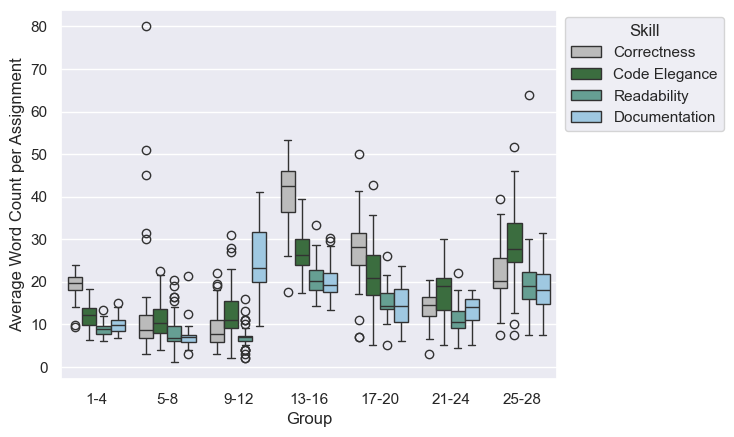

In [254]:
length_plt = sns.boxplot(feedback_df_mean, x='group', y='length', hue='skill', dodge=True, palette=sns.color_palette([grey, darkgreen, teal, blue]), hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])
length_plt.set(xlabel='Group', ylabel='Average Word Count per Assignment')
sns.move_legend(length_plt, "upper left", bbox_to_anchor=(1, 1), title='Skill')
length_plt.get_figure().savefig('plots/inter_rater_length.pdf', bbox_inches='tight')

### Comment Similarity

In [188]:
inter_rater_sim_df = pd.read_csv('../data/inter_rater_sim.csv')
inter_rater_sim_df = inter_rater_sim_df[(inter_rater_sim_df['feedback_1'] != 'No comment supplied' ) & (inter_rater_sim_df['feedback_2'] != 'No comment supplied')]

inter_rater_sim_df_mean = inter_rater_sim_df[['group', 'skill', 'assignment_number', 'sim']].groupby(['skill', 'group', 'assignment_number']).mean().reset_index()
inter_rater_sim_df_mean['group'] = pd.Categorical(inter_rater_sim_df_mean['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
inter_rater_sim_df_mean = inter_rater_sim_df_mean.sort_values('group', ascending=True)
inter_rater_sim_df_mean.head()

,skill,group,assignment_number,sim
0,Code Elegance,1-4,29.0,0.332499
254,Correctness,1-4,575.0,0.529909
255,Correctness,1-4,588.0,0.369967
256,Correctness,1-4,601.0,0.515460
257,Correctness,1-4,612.0,0.450692


In [200]:
inter_rater_sim_df_mean[['group', 'skill', 'sim']].groupby(['group', 'skill'], observed=True).mean().sort_values(['sim'], ascending=False)

,,sim
group,skill,
25-28,Correctness,0.439806
1-4,Documentation,0.430350
13-16,Readability,0.425498
1-4,Correctness,0.420052
25-28,Readability,0.418868
13-16,Documentation,0.403042
25-28,Code Elegance,0.392716
13-16,Code Elegance,0.392158
17-20,Readability,0.378710


In [203]:
inter_rater_sim_df[(inter_rater_sim_df['group'] == '1-4')][['skill', 'sim']].groupby(['skill']).mean()

,sim
skill,
Code Elegance,0.363277
Correctness,0.421957
Documentation,0.430153
Readability,0.370913


In [207]:
inter_rater_sim_df[(inter_rater_sim_df['group'] == '5-8') & (inter_rater_sim_df['skill'] == 'Correctness') & (inter_rater_sim_df['assignment_number'] == 31)].sort_values('sim', ascending=False)

,group,skill,assignment_number,participant_id_1,participant_id_2,feedback_1,feedback_2,sim
1636,5-8,Correctness,31.0,6,8,At least 2 predators do not compete for same f...,some challenge tasks are not completed such as...,0.188940
1637,5-8,Correctness,31.0,7,8,It is basically correct.,some challenge tasks are not completed such as...,0.068101
1635,5-8,Correctness,31.0,6,7,At least 2 predators do not compete for same f...,It is basically correct.,0.035060


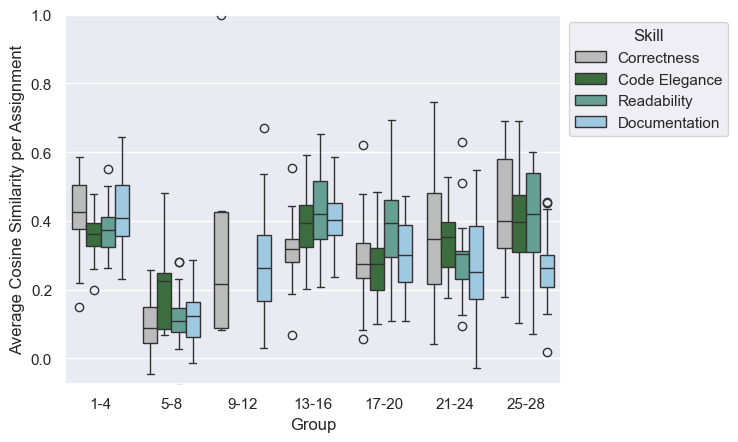

In [223]:
g = sns.boxplot(inter_rater_sim_df_mean, x='group', y='sim', hue='skill', palette=sns.color_palette([grey, darkgreen, teal, blue]), hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])
g.set(xlabel='Group', ylabel='Average Cosine Similarity per Assignment', ylim=(-0.075, 1))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Skill')
g.get_figure().savefig('plots/inter_rater_sim.pdf', bbox_inches='tight')

## Dominant Topic
- Use nominal Krippendorf's and Gwet's AC1

In [82]:
correctness_dominant_df = pd.read_csv('../data/dominant_topics_correctness.csv')
correctness_dominant_df['skill'] = 'Correctness'

ce_dominant_df = pd.read_csv('../data/dominant_topics_code_elegance.csv')
ce_dominant_df['skill'] = 'Code Elegance'

read_dominant_df = pd.read_csv('../data/dominant_topics_readability.csv')
read_dominant_df['skill'] = 'Readability'

doc_dominant_df = pd.read_csv('../data/dominant_topics_documentation.csv')
doc_dominant_df['skill'] = 'Documentation'

dominant_df = pd.concat([correctness_dominant_df, ce_dominant_df, read_dominant_df, doc_dominant_df])

dominant_df = dominant_df[dominant_df['assignment_number'] != 105]

dominant_df['skill'].value_counts()

skill
Correctness      710
Documentation    707
Code Elegance    674
Readability      628
Name: count, dtype: int64

In [83]:
dominant_df['group'] = dominant_df['participant_id'].apply(map_participant_group)
dominant_df['group'] = pd.Categorical(dominant_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
dominant_df = dominant_df.sort_values('group', ascending=True)
dominant_df['Dominant_Topic'] = pd.Categorical(dominant_df['Dominant_Topic'])

# dominant_df = dominant_df[dominant_df['group'] != '9-12']
dominant_df.head()

,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics,skill,group
652,601.0,Code could make use of abstract classes to imp...,2,1,"['code', 'use', 'abstract', 'class', 'extensib...",Code Structure,0.525240,"structure, readable, extensibility, repetition...","[('Code Structure', 0.5252403), ('Inheritance'...",Code Elegance,1-4
626,234.0,Good readability.,1,1,['good'],Naming and Whitespace,0.500000,"naming, improve, indentation, consistent, orga...","[('Naming and Whitespace', 0.5), ('Structure',...",Readability,1-4
625,601.0,Generally good readability.,1,1,['good'],Naming and Whitespace,0.500000,"naming, improve, indentation, consistent, orga...","[('Naming and Whitespace', 0.5), ('Structure',...",Readability,1-4
624,629.0,Some unconvential shorthands are used for some...,1,1,"['unconvential', 'shorthand', 'use']",Naming and Whitespace,0.500000,"naming, improve, indentation, consistent, orga...","[('Naming and Whitespace', 0.5), ('Structure',...",Readability,1-4
623,588.0,Inconsistent casing where unnecessary. General...,1,1,"['inconsistent', 'casing', 'unnecessary', 'good']",Structure,0.746754,"structure, clear, readable, comment, understan...","[('Structure', 0.7467537), ('Naming and Whites...",Readability,1-4


In [84]:
dominant_df['Dominant_Topic'].unique()

['Code Structure', 'Naming and Whitespace', 'Structure', 'Areas of Improvement', 'Compilation/Errors', 'Quality', 'Design', 'Inheritance', 'Areas of Achievement', 'Implementation/Creativity']
Categories (10, object): ['Areas of Achievement', 'Areas of Improvement', 'Code Structure', 'Compilation/Errors', ..., 'Inheritance', 'Naming and Whitespace', 'Quality', 'Structure']

### Distribution per group

In [85]:
dist_df = dominant_df.copy().sort_values(['skill', 'group', 'participant_id'])
dist_df.head()

,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics,skill,group
658,316.0,Animals and Plants extend Entity. Animals may ...,1,1,"['entity', 'abstract', 'class', 'extendability']",Inheritance,0.666597,"abstract, hierarchy, reusability, maintainable...","[('Inheritance', 0.66659683), ('Design', 0.166...",Code Elegance,1-4
659,554.0,Program shows good opportunity for extendabili...,1,1,"['program', 'opportunity', 'extendability', 'h...",Inheritance,0.333333,"abstract, hierarchy, reusability, maintainable...","[('Inheritance', 0.33333334), ('Design', 0.333...",Code Elegance,1-4
660,274.0,Class hierarchy works well. A lot of variables...,1,1,"['class', 'hierarchy', 'work', 'clear', 'use',...",Inheritance,0.665956,"abstract, hierarchy, reusability, maintainable...","[('Inheritance', 0.66595596), ('Code Structure...",Code Elegance,1-4
661,36.0,Class hierarchy makes sense. Final variables t...,1,1,"['class', 'hierarchy', 'sense', 'final', 'requ...",Inheritance,0.665955,"abstract, hierarchy, reusability, maintainable...","[('Inheritance', 0.66595465), ('Code Structure...",Code Elegance,1-4
662,522.0,Code is generally implemented well. Some incon...,1,1,"['inconsistent', 'design', 'decision', 'low', ...",Design,0.666623,"design, implementation, approach, modularity, ...","[('Design', 0.6666234), ('Code Structure', 0.1...",Code Elegance,1-4


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13516/990348499.py:6: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.histplot(dist_df[dist_df['group'] == groups[i]], x='participant_id', hue='skill', multiple='stack', discrete=True, ax=axs[i], legend=False, palette=color_pallete)
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13516/990348499.py:6: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.histplot(dist_df[dist_df['group'] == groups[i]], x='participant_id', hue='skill', multiple='stack', discrete=True, ax=axs[i], legend=False, palette=color_pallete)
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13516/990348499.py:6: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.histplot(dist_df[dist_df['group'] == groups[i]], x='participant_id', hue='skill', multiple='stack', discrete=True, ax=axs[i], legen

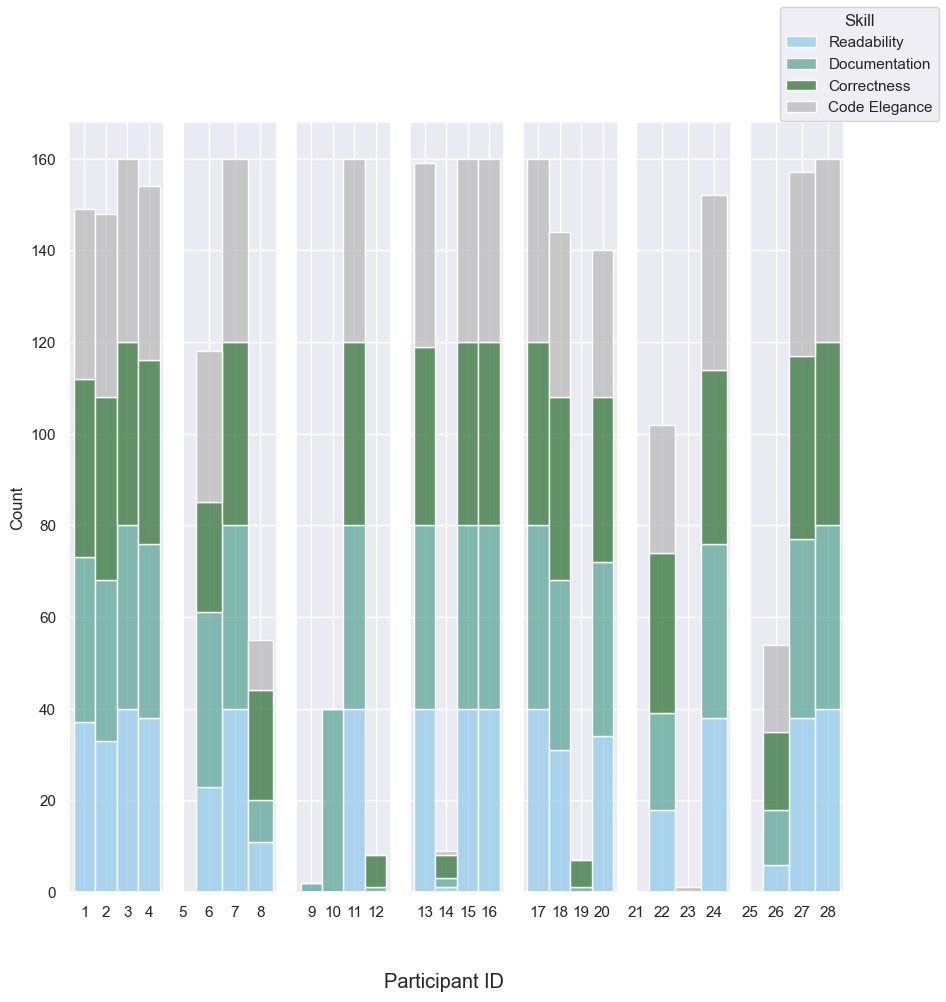

In [86]:
fig, axs = plt.subplots(1, 7, figsize=(10, 10), sharey=True)

groups = dist_df['group'].unique().tolist()

for i in range(len(groups)):
    sns.histplot(dist_df[dist_df['group'] == groups[i]], x='participant_id', hue='skill', multiple='stack', discrete=True, ax=axs[i], legend=False, palette=color_pallete)
    group_split = groups[i].split('-')
    axs[i].set_xticks(range(int(group_split[0]), int(group_split[1]) + 1))
    axs[i].set(xlabel='')
    # plt.tight_layout(pad=2)
    
    
fig.supxlabel('Participant ID')
fig.legend(labels=['Readability', 'Documentation', 'Correctness', 'Code Elegance'], loc='upper right', title='Skill')
fig.savefig('plots/feedback_dist_participant.pdf', bbox_inches='tight')

### Inter-rater metrics
All calculations are based on those that have provided feedback for the skill. For example, in group 21-24, only 22 and 24 gave feedback all on four topics, 21 provided no feedback and 23 provided 1 piece of feedback for code elegance.
So for the other skills, the metrics are calculated between the two raters 22 and 24, instead of four raters.

#### Group 9-12
Krippendorf's Alpha Results
- Correctness - Participants 11 and 12 provided feedback, with 11 providing feedback on all assignments, 12 only provided feedback on 7 and only gave feedback on the same topic.
    - As only unique pair existed $=> m_u = 1$ and $o_{ck} = \sum_{u}{\frac{\text{Number of } c-k \text{ pairs in unit } u}{m_u - 1}}$ therefore, $m_u - 1 = 0$ and results in a Zero Division Error
- Code Elegance - Only one rater (11) provided ratings
- Readability - Only one rater (11) provided ratings
- Documentation - Only skill that two raters (10 and 11) provided feedback on for all 40 assignments, 9 provided 2 pieces of feedback, and 12 provided 1.

AC1 Results
- Correctness - As participant 12 only gave feed back on one topic
    - $p_{k+} = 1, p_{+k} = 1 => \pi_k = 0 => p_e = 0$
    - $p_a = 1$
    - $\gamma = \frac{p_a - p_e}{1 - p_e} = 1$
- Code elegance and readability - only one rater
- Documentation - see above

In [133]:
# dominant_df = dominant_df[dominant_df['group'] != '9-12']
dominant_df['participant_id'].unique()

array([ 2,  1,  3,  4,  7,  8,  6, 11, 10, 12,  9, 13, 16, 15, 14, 18, 17,
       19, 20, 24, 22, 23, 28, 27, 26])

In [108]:
# Topics are norminal

def calculate_krippendorrf_alpha(skill, group):
    skill_df = dominant_df[dominant_df['skill'] == skill][['participant_id', 'assignment_number', 'group', 'Dominant_Topic']].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df['Dominant_Topic'] = group_df['Dominant_Topic'].cat.codes
    
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values='Dominant_Topic')

    return krippendorff.alpha(pivot.to_numpy(), level_of_measurement='nominal')

In [112]:
calculate_krippendorrf_alpha('Correctness', '9-12')

/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/krippendorff/krippendorff.py:364: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - (o * d).sum() / (e * d).sum()


nan

In [118]:
def calculate_ac1(skill, group):
    skill_df = dominant_df[dominant_df['skill'] == skill][['participant_id', 'assignment_number', 'group', 'Dominant_Topic']].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df['Dominant_Topic'] = group_df['Dominant_Topic'].cat.codes
    # Transpose pivot to get in form required by library rater by assignment
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values='Dominant_Topic').T
    
    cac = CAC(pivot)

    return cac.gwet()['est']['coefficient_value']

In [119]:
calculate_ac1('Correctness', '9-12')

1.0

In [120]:
def calculate_all_reliability_metric(metric):
    results_df = None

    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for group in dominant_df['group'].unique():
            try:
                if metric == 'krippendorff':
                    metric_result = calculate_krippendorrf_alpha(skill, group)
                else:
                    metric_result = calculate_ac1(skill, group)
                
            except ValueError as e:
                print(f'Error entries check data for: {group} - {skill} \n Error: {e}')
                metric_result = np.nan
            except RuntimeWarning as e:
                print(f'Math error, probably ZeroDivision, see: {e}')
                metric_result = np.nan

            results_df = pd.concat([results_df, pd.DataFrame({
                'group': group,
                'skill': skill,
                'metric_result': metric_result}, index=[0])])

            results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])

    return results_df

In [125]:
alpha_df = calculate_all_reliability_metric('krippendorff').sort_values(by='group')
alpha_df

Math error, probably ZeroDivision, see: invalid value encountered in scalar divide
Error entries check data for: 9-12 - Readability 
 Error: There has to be at least one unit with values assigned by at least two coders.
Error entries check data for: 9-12 - Code Elegance 
 Error: There has to be more than one value in the domain.


,group,skill,metric_result
0,1-4,Correctness,-0.176107
0,1-4,Documentation,-0.060932
0,1-4,Code Elegance,0.003680
0,1-4,Readability,0.017096
0,5-8,Correctness,-0.132075
0,5-8,Code Elegance,-0.333140
0,5-8,Documentation,-0.295933
0,5-8,Readability,-0.297872
0,9-12,Code Elegance,NaN
0,9-12,Documentation,-0.105392


In [130]:
alpha_df[['skill', 'metric_result']].groupby(['skill']).mean()

,metric_result
skill,
Code Elegance,-0.181853
Correctness,-0.112135
Documentation,-0.108340
Readability,-0.196082


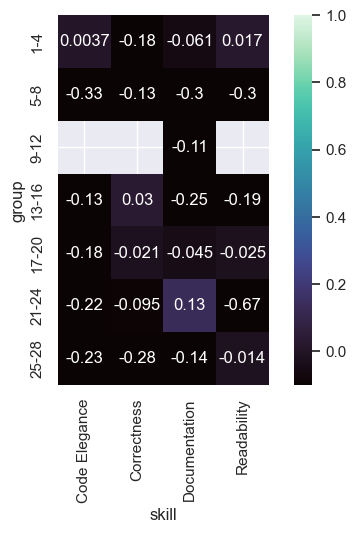

In [122]:
# Errors thrown here as 9-12 only has one rater in two topics

pivot_df = alpha_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
# g.get_figure().savefig('plots/krippendorrf.pdf', bbox_inches='tight')

In [123]:
# Errors thrown here as 9-12 only has one rater in two topics

ac1_df = calculate_all_reliability_metric('ac1').sort_values(by='group')
ac1_df.head()

Math error, probably ZeroDivision, see: invalid value encountered in scalar divide
Math error, probably ZeroDivision, see: invalid value encountered in scalar divide


,group,skill,metric_result
0,1-4,Correctness,0.03141
0,1-4,Documentation,0.09163
0,1-4,Code Elegance,0.39224
0,1-4,Readability,0.31664
0,5-8,Correctness,0.26097


In [132]:
ac1_df[['skill', 'metric_result']].groupby(['skill']).mean()

,metric_result
skill,
Code Elegance,0.071180
Correctness,0.437709
Documentation,0.146137
Readability,0.032435


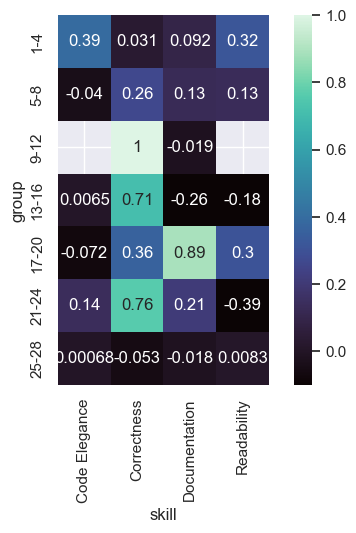

In [96]:
pivot_df = ac1_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/ac1.pdf', bbox_inches='tight')

In [97]:
dominant_df[(dominant_df['group'] == '9-12') & (dominant_df['skill'] == 'Correctness')][['Dominant_Topic', 'participant_id', 'comments']].groupby(['Dominant_Topic', 'participant_id']).count()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13516/1072490072.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dominant_df[(dominant_df['group'] == '9-12') & (dominant_df['skill'] == 'Correctness')][['Dominant_Topic', 'participant_id', 'comments']].groupby(['Dominant_Topic', 'participant_id']).count()


comments
Dominant_Topic            participant_id          
Areas of Achievement      11                     0
                          12                     0
Areas of Improvement      11                     0
                          12                     0
Code Structure            11                     0
                          12                     0
Compilation/Errors        11                    35
                          12                     7
Design                    11                     0
                          12                     0
Implementation/Creativity 11                     3
                          12                     0
Inheritance               11                     0
                          12                     0
Naming and Whitespace     11                     0
                          12                     0
Quality                   11                     2
                          12                     0
Structure                 11                     0
                          12                     0

#### Krippendorf's vs Threshold

In [98]:
experience_df = pd.read_csv('../data/experience_formatted.csv')
experience_df['group'] = experience_df['participant_id'].apply(map_participant_group)
exp_alpha_df = pd.merge(experience_df, alpha_df, on='group', how='right')
exp_alpha_df

,Unnamed: 0,participant_id,prog_exp,grading_exp,group,skill,metric_result
0,2,4,5+ years,No grading \n experience,1-4,Correctness,-0.176107
1,6,3,5+ years,1 - 2 years,1-4,Correctness,-0.176107
2,9,2,5+ years,No grading \n experience,1-4,Correctness,-0.176107
3,14,1,5+ years,0 - 1 years,1-4,Correctness,-0.176107
4,2,4,5+ years,No grading \n experience,1-4,Documentation,-0.060932
...,...,...,...,...,...,...,...
107,26,28,5+ years,No grading \n experience,25-28,Code Elegance,-0.226753
108,10,25,5+ years,No grading \n experience,25-28,Documentation,-0.135566
109,17,26,3 - 5 years,0 - 1 years,25-28,Documentation,-0.135566
110,18,27,5+ years,No grading \n experience,25-28,Documentation,-0.135566


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13516/4166618091.py:4: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  g_inter_exp_box_plt = sns.boxplot(exp_alpha_df, x='grading_exp', y='metric_result', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_pallete, ax=inter_exp_plt.ax_joint)


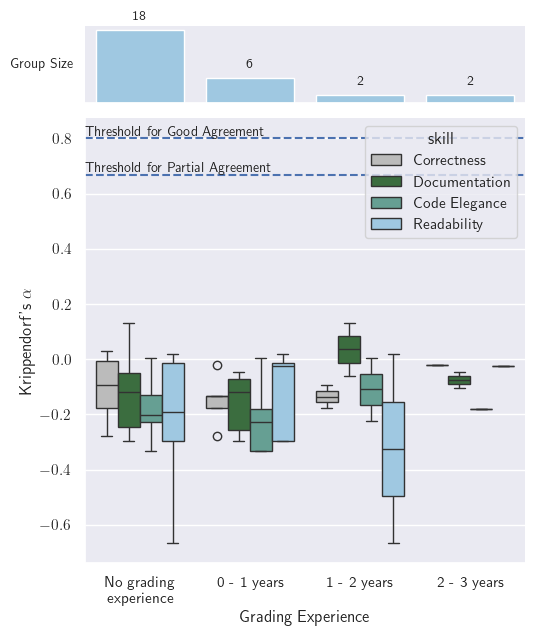

In [99]:
sns.set(rc={'text.usetex': True})

inter_exp_plt = sns.JointGrid()
g_inter_exp_box_plt = sns.boxplot(exp_alpha_df, x='grading_exp', y='metric_result', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_pallete, ax=inter_exp_plt.ax_joint)
sns.countplot(experience_df, x='grading_exp', ax=inter_exp_plt.ax_marg_x, color=blue)
inter_exp_plt.ax_marg_y.remove()

g_inter_exp_box_plt.set(xlabel='Grading Experience', ylabel="Krippendorf's $\\alpha$")

inter_exp_plt.ax_marg_x.set_title('Group Size', fontsize=10, loc='left', y=0.35, x=-0.17)

inter_exp_plt.ax_joint.axhline(0.667, ls='--')
inter_exp_plt.ax_joint.axhline(0.8, ls='--')
inter_exp_plt.ax_joint.text(-0.5, 0.68, 'Threshold for Partial Agreement', fontsize=10)
inter_exp_plt.ax_joint.text(-0.5, 0.81, 'Threshold for Good Agreement', fontsize=10)

for p in inter_exp_plt.ax_marg_x.patches:
    inter_exp_plt.ax_marg_x.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

inter_exp_plt.savefig('plots/inter_exp_dist.pdf', bbox_inches='tight')
sns.set(rc={'text.usetex': False})